In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [0]:
if os.path.isfile('nlp_features_train.csv'):
    df= pd.read_csv("nlp_features_train.csv",encoding='latin-1',nrows=100000)

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [0]:
y_true = df['is_duplicate']
y_true = list(map(int, y_true.values))

In [0]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
#Splitting the dataset
df_train,df_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merge texts
questions_train = list(df_train['question1']) + list(df_train['question2'])
#tfidf on train data 
tfidf= TfidfVectorizer()
questions_train_tfidf=tfidf.fit_transform(questions_train)

In [0]:
questions_test = list(df_test['question1']) + list(df_test['question2'])
#Tfidf on test data
questions_test_tfidf=tfidf.transform(questions_test)

In [0]:
#droping all the other coloumn apart from the features
df_train.drop(['id',"question1",'question2', 'qid1','qid2','is_duplicate'], axis=1, inplace=True)
df_test.drop(['id',"question1",'question2', 'qid1','qid2','is_duplicate'], axis=1, inplace=True)


In [0]:
import scipy
dfnlp_train_array=scipy.sparse.csr_matrix(df_train.values)
dfnlp_test_array=scipy.sparse.csr_matrix(df_test.values)

In [0]:
#adding the tfidf features to rest of the features
#from scipy.sparse import hstack
dfnlp_train_array=hstack([dfnlp_train_array,questions_train_tfidf[:70000][:]])
dfnlp_train_array=hstack([dfnlp_train_array,questions_train_tfidf[70000:][:]])
dfnlp_test_array=hstack([dfnlp_test_array,questions_test_tfidf[:30000][:]])
dfnlp_test_array=hstack([dfnlp_test_array,questions_test_tfidf[30000:][:]])
dfnlp_train_array.shape
dfnlp_test_array.shape

(30000, 77971)

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

##### Logistic regression with l2 regularization 

For values of alpha =  1e-09 The log loss is: 0.6602902109101164
For values of alpha =  1e-08 The log loss is: 0.5954062192784096
For values of alpha =  1e-07 The log loss is: 0.6602902109101164
For values of alpha =  1e-06 The log loss is: 0.568958141068574
For values of alpha =  1e-05 The log loss is: 0.5690824788043827
For values of alpha =  0.0001 The log loss is: 0.5689828925194409
For values of alpha =  0.001 The log loss is: 0.5697209977572819
For values of alpha =  0.01 The log loss is: 0.5771804723981262
For values of alpha =  0.1 The log loss is: 0.5892897001865278
For values of alpha =  1 The log loss is: 0.5982032207701903
For values of alpha =  10 The log loss is: 0.6088802385182616


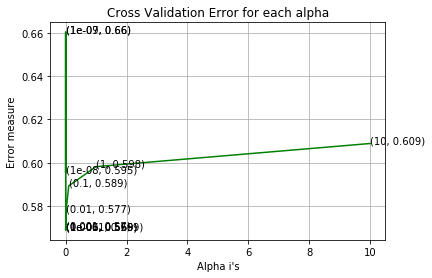

For values of best alpha =  1e-06 The train log loss is: 0.5642840556723476
For values of best alpha =  1e-06 The test log loss is: 0.568958141068574
Total number of data points : 30000


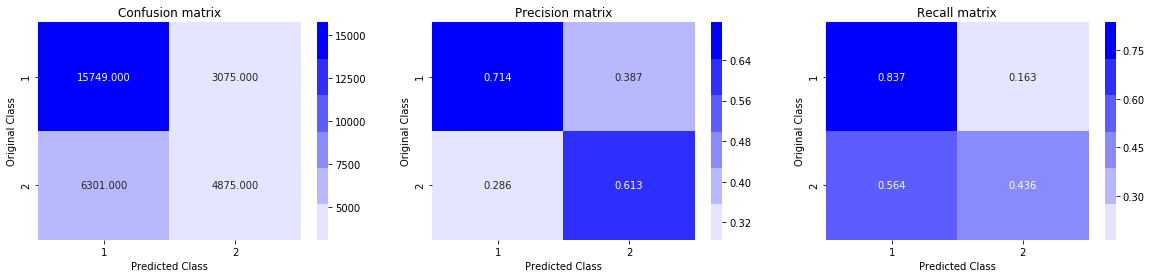

In [0]:
alpha = [10 ** x for x in range(-9, 2)] # hyperparam for SGD classifier.
#alpha=[0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(dfnlp_train_array, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(dfnlp_train_array, y_train)
    predict_y = sig_clf.predict_proba(dfnlp_test_array)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(dfnlp_train_array, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(dfnlp_train_array, y_train)

predict_y = sig_clf.predict_proba(dfnlp_train_array)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(dfnlp_test_array)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##### Logistic Regression with l1 reglarization 

For values of alpha =  1e-09 The log loss is: 0.6602902109101164
For values of alpha =  1e-08 The log loss is: 0.6205816679182411
For values of alpha =  1e-07 The log loss is: 0.5831438291318164
For values of alpha =  1e-06 The log loss is: 0.5596089609700047
For values of alpha =  1e-05 The log loss is: 0.5669041556717577
For values of alpha =  0.0001 The log loss is: 0.5647276850082357
For values of alpha =  0.001 The log loss is: 0.5806856539830687
For values of alpha =  0.01 The log loss is: 0.5813026914556049
For values of alpha =  0.1 The log loss is: 0.6068383071191201
For values of alpha =  1 The log loss is: 0.5920837334370694
For values of alpha =  10 The log loss is: 0.6602902102099689


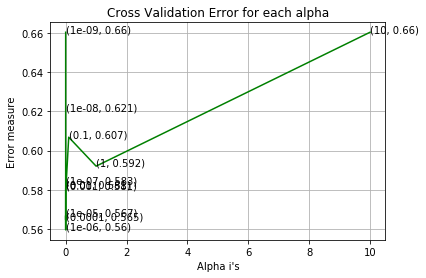

For values of best alpha =  1e-06 The train log loss is: 0.5545080920425556
For values of best alpha =  1e-06 The test log loss is: 0.5596089609700047
Total number of data points : 30000


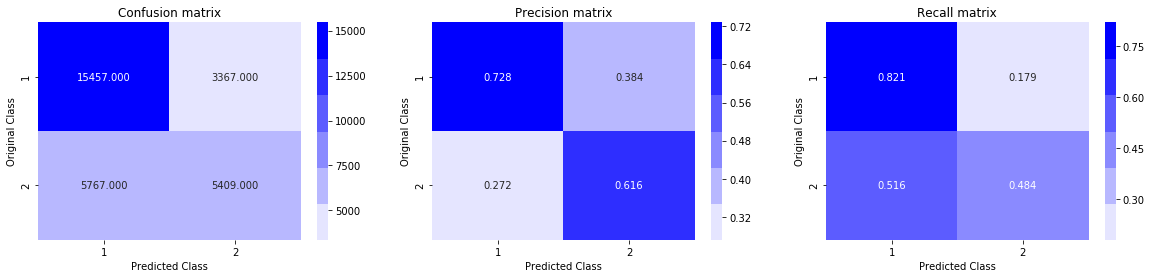

In [0]:
alpha = [10 ** x for x in range(-9, 2)] # hyperparam for SGD classifier.
#alpha=[0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='log', random_state=42)
    clf.fit(dfnlp_train_array, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(dfnlp_train_array, y_train)
    predict_y = sig_clf.predict_proba(dfnlp_test_array)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='log', random_state=42)
clf.fit(dfnlp_train_array, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(dfnlp_train_array, y_train)

predict_y = sig_clf.predict_proba(dfnlp_train_array)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(dfnlp_test_array)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##### Linear  Svm with l1 regularization 

For values of alpha =  1e-09 The log loss is: 0.6602902109101164
For values of alpha =  1e-08 The log loss is: 0.6163672913926453
For values of alpha =  1e-07 The log loss is: 0.6154734390555342
For values of alpha =  1e-06 The log loss is: 0.5748124773798879
For values of alpha =  1e-05 The log loss is: 0.5780257546818638
For values of alpha =  0.0001 The log loss is: 0.5692676364767862
For values of alpha =  0.001 The log loss is: 0.5764221105728721
For values of alpha =  0.01 The log loss is: 0.5843627481095435
For values of alpha =  0.1 The log loss is: 0.6138096137719478
For values of alpha =  1 The log loss is: 0.6596211546323143


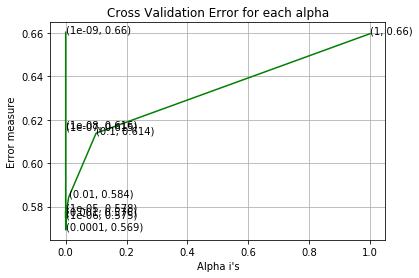

For values of best alpha =  0.0001 The train log loss is: 0.5648536954040291
For values of best alpha =  0.0001 The test log loss is: 0.5692676364767862
Total number of data points : 30000


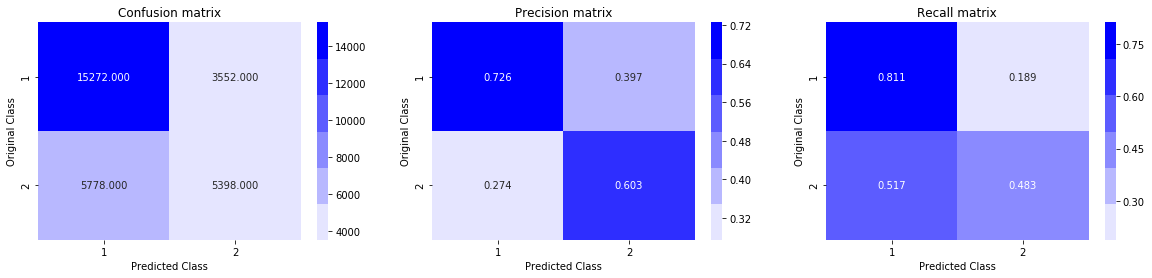

In [0]:
alpha = [10 ** x for x in range(-9, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(dfnlp_train_array, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(dfnlp_train_array, y_train)
    predict_y = sig_clf.predict_proba(dfnlp_test_array)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(dfnlp_train_array, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(dfnlp_train_array, y_train)

predict_y = sig_clf.predict_proba(dfnlp_train_array)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(dfnlp_test_array)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##### Linear Svm with l2 regularization 

For values of alpha =  1e-09 The log loss is: 0.6602902109101164
For values of alpha =  1e-08 The log loss is: 0.6263638279196706
For values of alpha =  1e-07 The log loss is: 0.5961777222750653
For values of alpha =  1e-06 The log loss is: 0.5707830352869686
For values of alpha =  1e-05 The log loss is: 0.5689730214074001
For values of alpha =  0.0001 The log loss is: 0.5865430598625423
For values of alpha =  0.001 The log loss is: 0.5699391737125591
For values of alpha =  0.01 The log loss is: 0.5810681832535901
For values of alpha =  0.1 The log loss is: 0.5919979595707057
For values of alpha =  1 The log loss is: 0.6018874115962805


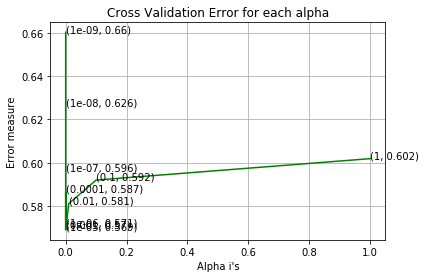

For values of best alpha =  1e-05 The train log loss is: 0.5641899205152117
For values of best alpha =  1e-05 The test log loss is: 0.5689730214074001
Total number of data points : 30000


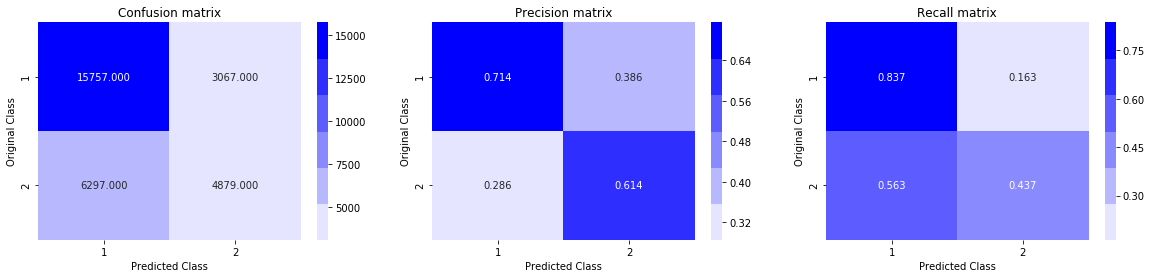

In [0]:
alpha = [10 ** x for x in range(-9, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(dfnlp_train_array, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(dfnlp_train_array, y_train)
    predict_y = sig_clf.predict_proba(dfnlp_test_array)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(dfnlp_train_array, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(dfnlp_train_array, y_train)

predict_y = sig_clf.predict_proba(dfnlp_train_array)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(dfnlp_test_array)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##### Words to vecotors representation  

In [0]:
word2tfidf= dict(zip(tfidf.get_feature_names(), tfidf.idf_))


In [0]:
from tqdm import tqdm
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_train['q1_feats_m'] = list(vecs1)


100%|██████████| 70000/70000 [17:50<00:00, 65.41it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(df_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_train['q2_feats_m'] = list(vecs2)

100%|██████████| 70000/70000 [18:30<00:00, 63.05it/s]


In [0]:

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df_test['q1_feats_m'] = list(vecs1)


100%|██████████| 30000/30000 [08:22<00:00, 59.75it/s]


In [0]:
vecs2 = []
for qu2 in tqdm(list(df_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df_test['q2_feats_m'] = list(vecs2)

100%|██████████| 30000/30000 [08:27<00:00, 59.13it/s]


In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1',nrows=100000)
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1',nrows=100000)
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
dfnlp_train,dfnlp_test, y_train, y_test = train_test_split(dfnlp, y_true, stratify=y_true, test_size=0.3)

In [0]:
dfppro_train,dfppro_test, y_train, y_test= train_test_split(dfppro, y_true, stratify=y_true, test_size=0.3)

In [0]:
df1_train= dfnlp_train.drop(['qid1','qid2','question1','question2'],axis=1)
df2_train= dfppro_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_train= df_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1_train= pd.DataFrame(df3_train.q1_feats_m.values.tolist(), index= df3_train.index)
df3_q2_train= pd.DataFrame(df3_train.q2_feats_m.values.tolist(), index= df3_train.index)

In [0]:
df1_test= dfnlp_test.drop(['qid1','qid2','question1','question2'],axis=1)
df2_test= dfppro_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_test= df_test.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1_test= pd.DataFrame(df3_test.q1_feats_m.values.tolist(), index= df3_test.index)
df3_q2_test= pd.DataFrame(df3_test.q2_feats_m.values.tolist(), index= df3_test.index)

In [0]:
print("Number of features in nlp dataframe :", df1_train.shape)
print("Number of features in preprocessed dataframe :", df2_train.shape)
print("Number of features in question1 w2v  dataframe :", df3_q1_train.shape)
print("Number of features in question2 w2v  dataframe :", df3_q2_train.shape)
print("Number of features in final dataframe  :", df1_train.shape[1]+df2_train.shape[1]+df3_q1_train.shape[1]+df3_q2_train.shape[1])

Number of features in nlp dataframe : (70000, 17)
Number of features in preprocessed dataframe : (70000, 12)
Number of features in question1 w2v  dataframe : (70000, 384)
Number of features in question2 w2v  dataframe : (70000, 384)
Number of features in final dataframe  : 797


In [0]:
print("Number of features in nlp dataframe :", df1_test.shape)
print("Number of features in preprocessed dataframe :", df2_test.shape)
print("Number of features in question1 w2v  dataframe :", df3_q1_test.shape)
print("Number of features in question2 w2v  dataframe :", df3_q2_test.shape)
print("Number of features in final dataframe  :", df1_test.shape[1]+df2_test.shape[1]+df3_q1_test.shape[1]+df3_q2_test.shape[1])

Number of features in nlp dataframe : (30000, 17)
Number of features in preprocessed dataframe : (30000, 12)
Number of features in question1 w2v  dataframe : (30000, 384)
Number of features in question2 w2v  dataframe : (30000, 384)
Number of features in final dataframe  : 797


In [0]:
df1_train.shape

(70000, 17)

In [0]:
df3_q2_train.shape

(70000, 384)

In [0]:
df1_train=df1_train.reset_index()
df2_train=df2_train.reset_index()
df3_q1_train=df3_q1_train.reset_index()
df3_q2_train=df3_q2_train.reset_index()

In [0]:
#Concatinaing the nlp dataset with w2v dataset 
df1_train = pd.concat([df1_train,df2_train],axis = 1)
df2_train = pd.concat([df3_q1_train,df3_q2_train],axis = 1)

In [0]:
result_train = pd.concat([df1_train,df2_train],axis = 1)

In [0]:
result_train.head()

,index,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,index,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,index,0,1,2,3,4,5,6,7,...,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,74611,74611,1,0.399992,0.333328,0.749981,0.428565,0.499995,0.416663,1.0,0.0,2.0,11.0,61,56,60,62,0.327869,59185,59185,1,1,69,117,10,22,3.0,29.0,0.103448,2,0,89219,-23.233478,20.966619,30.225081,114.263924,24.525153,-36.772067,-15.483834,-30.737158,...,-5.814881,1.109631,-16.632919,6.137824,33.837418,-4.413437,-8.500891,15.680623,-13.637761,-1.345670,3.110732,-3.348327,-13.680611,-24.458942,8.712298,-22.784646,-4.600163,12.004958,0.570511,12.273547,-18.437158,-7.083554,11.061953,-6.386901,18.570199,19.392973,-11.722478,16.358914,-6.270665,0.308357,7.153372,15.982771,6.969848,0.870685,7.895045,12.883818,-2.617755,10.593025,5.975981,7.748031
1,89685,89685,0,0.599988,0.374995,0.199996,0.142855,0.399996,0.249998,0.0,0.0,6.0,13.0,59,58,44,57,0.436364,21432,21432,5,16,34,28,7,6,5.0,13.0,0.384615,21,11,72282,-45.096929,66.418319,76.887451,12.467055,-57.819697,1.644260,-183.059468,36.709689,...,-7.766950,4.605679,-21.226973,16.441550,21.834147,-4.759939,-1.346978,-7.709628,-12.185819,26.217797,4.871496,-14.236735,14.424055,-11.990687,-7.788291,-32.706924,-12.536163,12.838678,20.588666,12.206390,-21.392323,-11.018517,6.203184,-9.099915,20.192547,18.452603,-5.841756,-5.739132,-14.755506,-6.553591,13.386359,19.406051,19.903439,-10.752081,14.473622,-1.992649,-16.801411,2.176561,10.079200,-3.414183
2,28062,28062,1,0.666644,0.499988,0.666644,0.333328,0.666656,0.399996,1.0,0.0,4.0,8.0,74,62,62,73,0.548387,67344,67344,1,2,32,28,7,7,6.0,14.0,0.428571,3,1,23200,44.337414,96.137690,45.836764,144.328885,102.809451,101.478195,-130.981872,-92.292357,...,-11.422078,-6.052541,-13.919183,14.272701,12.656606,-13.466490,0.447562,5.295064,-4.986209,11.859041,4.557491,-2.520877,-5.765444,-21.985971,-19.956796,-12.793188,-3.593756,25.850573,7.771542,4.479358,-14.240568,-8.019121,13.137531,-14.091727,19.268368,2.432394,-4.163967,5.465882,-13.722385,-7.533328,8.493829,21.429750,13.511009,-1.999219,5.215039,-3.962344,-8.666348,0.668789,-3.144228,1.280902
3,67424,67424,0,0.999988,0.888879,0.999967,0.999967,0.999991,0.916659,1.0,1.0,1.0,11.5,100,97,97,97,0.945205,28000,28000,1,1,108,81,18,15,8.0,32.0,0.250000,2,0,83129,40.079948,29.204792,49.857268,136.565602,5.703157,21.592082,-40.812580,-11.647967,...,-10.995040,-1.214416,-8.580440,16.920591,12.119859,2.930320,-3.100902,11.044981,-14.582824,9.213462,-1.191803,-5.528443,-3.889506,-14.339288,-6.794386,-8.482185,0.018046,1.871896,11.069562,6.914493,-16.316106,-4.216006,7.480066,-3.272318,9.322786,1.828832,-7.338644,5.470517,-8.687053,5.106423,8.746120,7.953673,-2.621035,-3.568263,0.630677,5.093877,-8.526610,-3.140861,9.228463,2.159410
4,9344,9344,1,0.999950,0.999950,0.999980,0.999980,0.999986,0.999986,0.0,0.0,0.0,7.0,100,100,78,81,0.481481,82286,82286,1,1,57,51,11,12,1.0,23.0,0.043478,2,0,66505,-2.940620,-19.010521,37.440550,27.456703,1.174612,-23.061048,-46.989389,16.955597,...,-12.258381,-5.166582,-25.257106,21.280120,14.637041,3.958710,-5.310293,10.877069,-12.890331,11.277733,22.827806,-2.818375,1.402986,-13.298579,-13.500939,-23.801484,-6.642805,6.438725,10.039060,11.493066,-15.770994,-15.124121,19.030112,3.392732,16.344453,12.206397,0.430146,16.876329,-17.102824,-0.449786,19.219178,9.334315,-0.095100,-3.736970,9.454558,1.758373,-13.213761,4.241951,11.737349,1.775651


In [0]:
#droping the unnececary coloumns 
result_train=result_train.drop(['index','id','is_duplicate'],axis=1)

In [0]:
df1_test=df1_test.reset_index()
df2_test=df2_test.reset_index()
df3_q1_test=df3_q1_test.reset_index()
df3_q2_test=df3_q2_test.reset_index()

In [0]:
#Concatinaing the nlp dataset with w2v dataset 
df1_test = pd.concat([df1_test,df2_test],axis = 1)
df2_test = pd.concat([df3_q1_test,df3_q2_test],axis = 1)

In [0]:
result_test= pd.concat([df1_test,df2_test],axis = 1)

In [0]:
result_test.head()
result_test=result_test.drop(['index','id','is_duplicate'],axis=1)

In [0]:
result_test.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,...,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383
0,0.499994,0.363633,0.374995,0.214284,0.411762,0.259258,0.0,0.0,10.0,22.0,62,58,52,56,0.173913,8,2,34,38,6,7,5.0,13.0,0.384615,10,6,-0.140951,2.576016,48.954648,23.033654,10.384424,-3.411469,-40.897828,-5.152277,30.180686,-36.886772,-42.866448,-46.173246,-11.162087,10.968820,...,-0.493257,-8.226297,-9.708421,3.034346,9.847488,1.444637,-12.948701,0.567892,-7.895530,4.718457,8.381740,-0.093025,-11.720758,-10.329991,-10.810695,-27.409598,-8.769037,1.668465,-0.118110,7.729484,-16.615356,-7.353649,7.609387,-2.002855,16.059116,-1.087245,-10.726329,13.479300,-4.583303,-1.146200,9.798299,12.695529,-4.058523,-1.222198,10.551836,5.250475,-6.603913,-6.620888,4.503741,1.989931
1,0.666644,0.222220,0.499975,0.249994,0.599988,0.230767,0.0,0.0,8.0,9.0,79,49,40,81,0.464286,2,2,37,38,7,6,4.0,13.0,0.307692,4,0,6.131585,57.542048,42.537987,7.444352,32.842792,-7.831354,-83.182433,3.065212,38.619208,-2.727940,5.368861,-35.395832,-15.306944,-30.440022,...,-14.258830,3.821678,-8.493801,12.026277,9.788678,-1.556660,-13.471947,12.667216,-10.462159,0.879016,15.098960,-9.757758,-1.154523,-5.768816,-6.662446,-24.105577,-7.630782,0.203830,18.077345,10.677082,-23.348811,-6.971658,2.482411,-3.706526,6.418175,7.791597,-10.595281,5.197162,-13.090099,4.771600,8.403120,8.147609,0.419264,0.733685,6.748346,3.577892,-1.384929,-0.852806,6.039180,7.822104
2,0.333322,0.333322,0.999967,0.999967,0.666656,0.666656,0.0,1.0,0.0,6.0,71,63,67,68,0.310345,1,2,48,48,10,10,7.0,20.0,0.350000,3,1,9.361938,36.252620,69.486477,-3.854656,16.445035,102.915929,-149.255497,-2.746756,59.685220,50.320514,59.936565,-40.221430,-5.981735,28.036434,...,-15.577823,9.323404,-13.812105,21.675137,28.284877,-15.099141,-11.123086,8.045709,-21.740741,26.037029,18.809775,-23.089187,8.727612,-8.050013,-4.955239,-39.821721,-4.195556,-4.084329,23.822887,16.594007,-25.465966,-26.134921,16.799619,-7.206056,7.411383,13.493095,-32.391803,2.829024,0.561150,-14.617146,-6.678006,18.114681,16.725924,-2.515477,3.316982,5.888334,1.644517,5.838237,21.896090,4.243033
3,0.999967,0.749981,0.249994,0.199996,0.571420,0.399996,0.0,1.0,3.0,8.5,79,67,67,78,0.324324,1,2,116,59,21,13,1.0,33.0,0.030303,3,1,61.427797,95.380267,30.261976,82.730036,-66.974308,52.813056,-83.728830,-26.772341,40.643774,33.819146,16.614540,-20.302010,42.394621,-36.309769,...,-13.523434,10.134674,-33.000559,24.730329,41.192130,-4.570421,-15.093572,11.802066,-36.430760,6.743201,8.522706,-16.584830,-3.206759,-22.069856,-8.205949,-25.652733,-5.051576,21.940600,1.176217,2.584700,-37.483439,-1.049482,-11.191187,-13.639756,34.717716,15.147626,-14.015036,5.521506,-19.054288,7.334387,8.451006,19.250457,5.452254,-7.634324,-2.851539,-2.786899,-7.066540,-6.306676,11.310937,8.896584
4,0.000000,0.000000,0.333322,0.166664,0.099999,0.066666,0.0,0.0,5.0,12.5,40,38,33,37,0.086957,1,1,23,26,5,6,5.0,11.0,0.454545,2,0,20.109340,14.893492,35.779469,83.165865,-55.939772,41.624348,-108.051318,-23.686439,65.067462,2.477761,15.648747,-21.826186,39.048663,-30.662271,...,2.733861,1.001282,-14.060040,12.839374,17.733983,4.513379,5.003077,17.747368,-8.976570,5.020010,6.199021,1.280101,-3.492117,-12.128049,4.746597,-18.818140,-2.267176,-2.501790,0.981585,-0.710407,-17.600412,-13.443553,11.607362,-7.050174,13.230993,3.103505,-11.334905,9.351623,1.864595,2.573048,0.361115,14.534470,8.529957,-0.862475,-3.182240,0.379638,-5.588511,2.519794,4.314106,2.825725


###### XGBoost classifer 

In [0]:
from xgboost import XGBClassifier
clf = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=150, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)
eval_set = [(result_train.values, y_train), (result_test.values, y_test)]
eval_metric = ["logloss"]
%time clf.fit(result_train.values, y_train, eval_metric=eval_metric, eval_set=eval_set,early_stopping_rounds=10, verbose=True)


[0]	validation_0-logloss:0.658662	validation_1-logloss:0.659214
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.637615	validation_1-logloss:0.638468
[2]	validation_0-logloss:0.611312	validation_1-logloss:0.612224
[3]	validation_0-logloss:0.587732	validation_1-logloss:0.588806
[4]	validation_0-logloss:0.573816	validation_1-logloss:0.575219
[5]	validation_0-logloss:0.553336	validation_1-logloss:0.554997
[6]	validation_0-logloss:0.536333	validation_1-logloss:0.538141
[7]	validation_0-logloss:0.522538	validation_1-logloss:0.524425
[8]	validation_0-logloss:0.510585	validation_1-logloss:0.51269
[9]	validation_0-logloss:0.502146	validation_1-logloss:0.504377
[10]	validation_0-logloss:0.491045	validation_1-logloss:0.493617
[11]	validation_0-logloss:0.482243	validation_1-logloss:0.484949
[12]	validation_0-logloss:0.474183	validation_1-logloss:0.47722
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

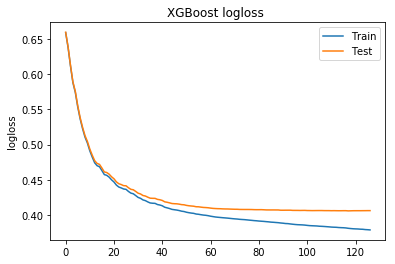

In [0]:
results = clf.evals_result()
iters = len(results['validation_0']['logloss'])
x = range(0, iters)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x, results['validation_0']['logloss'], label='Train')
ax.plot(x, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost logloss ')
plt.show()


###### Finding for best max depth

In [0]:
from xgboost import XGBClassifier
for i in range(6,12):
  
  clf = XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.1,  
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic', 
                        n_estimators=100, 
                        reg_alpha = 0.3,
                        max_depth=i,
                        gamma=10)
  eval_set = [(result_train.values, y_train), (result_test.values, y_test)]
  eval_metric = ["logloss"]
  %time clf.fit(result_train.values, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-logloss:0.657097	validation_1-logloss:0.657766
[1]	validation_0-logloss:0.635611	validation_1-logloss:0.636829
[2]	validation_0-logloss:0.609131	validation_1-logloss:0.61071
[3]	validation_0-logloss:0.585224	validation_1-logloss:0.587181
[4]	validation_0-logloss:0.570355	validation_1-logloss:0.572694
[5]	validation_0-logloss:0.5496	validation_1-logloss:0.552363
[6]	validation_0-logloss:0.532405	validation_1-logloss:0.5355
[7]	validation_0-logloss:0.518025	validation_1-logloss:0.521338
[8]	validation_0-logloss:0.505443	validation_1-logloss:0.50919
[9]	validation_0-logloss:0.497024	validation_1-logloss:0.501119
[10]	validation_0-logloss:0.485633	validation_1-logloss:0.490221
[11]	validation_0-logloss:0.475857	validation_1-logloss:0.480704
[12]	validation_0-logloss:0.467611	validation_1-logloss:0.473015
[13]	validation_0-logloss:0.463177	validation_1-logloss:0.468912
[14]	validation_0-logloss:0.461572	validation_1-logloss:0.467601
[15]	validation_0-logloss:0.456279	valida

###### Finding for the best gama

In [0]:
from xgboost import XGBClassifier
for i in [0.7,0.8,0.9,1]:
  
  clf = XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.1,  
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic', 
                        n_estimators=100, 
                        reg_alpha = 0.3,
                        max_depth=5,
                        gamma=i)
  eval_set = [(result_train.values, y_train), (result_test.values, y_test)]
  eval_metric = ["logloss"]
  %time clf.fit(result_train.values, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


[0]	validation_0-logloss:0.658509	validation_1-logloss:0.658871
[1]	validation_0-logloss:0.637758	validation_1-logloss:0.637989
[2]	validation_0-logloss:0.61113	validation_1-logloss:0.611804
[3]	validation_0-logloss:0.587631	validation_1-logloss:0.588616
[4]	validation_0-logloss:0.573619	validation_1-logloss:0.57482
[5]	validation_0-logloss:0.553795	validation_1-logloss:0.555394
[6]	validation_0-logloss:0.537075	validation_1-logloss:0.538843
[7]	validation_0-logloss:0.523344	validation_1-logloss:0.525251
[8]	validation_0-logloss:0.511101	validation_1-logloss:0.513166
[9]	validation_0-logloss:0.502403	validation_1-logloss:0.504671
[10]	validation_0-logloss:0.4913	validation_1-logloss:0.493879
[11]	validation_0-logloss:0.482166	validation_1-logloss:0.484962
[12]	validation_0-logloss:0.473883	validation_1-logloss:0.477008
[13]	validation_0-logloss:0.469627	validation_1-logloss:0.472971
[14]	validation_0-logloss:0.467991	validation_1-logloss:0.47161
[15]	validation_0-logloss:0.462611	valid

###### Using the best found parameters to print the confusion matrix

In [ ]:
clf = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=118, 
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=10)


clf.fit(result_train.values, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(result_train.values, y_train)

predict_y = sig_clf.predict_proba(result_train.values)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(result_test.values)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

###### Observations 

In [3]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
table= PrettyTable()
table.field_names = ["Model","Hyper-parameter(alpha)","Log Loss"]
table.add_row(["Logistic Regression with L2","10*-6",0.5689])
table.add_row(["Logistic Regression with L1","10*-6",0.5596])
table.add_row(["Linear SVM with L1","0.0001",0.5948])
table.add_row(["Linear SVM with L2","10*-5",0.5697])
table.add_row(["XGBoost","[n_estimators=118,max_depth=5,gamma=10,subsample=0.8]",0.4163])

In [4]:
print(table)

+-----------------------------+-------------------------------------------------------+----------+
|            Model            |                 Hyper-parameter(alpha)                | Log Loss |
+-----------------------------+-------------------------------------------------------+----------+
| Logistic Regression with L2 |                         10*-6                         |  0.5689  |
| Logistic Regression with L1 |                         10*-6                         |  0.5596  |
|      Linear SVM with L1     |                         0.0001                        |  0.5948  |
|      Linear SVM with L2     |                         10*-5                         |  0.5697  |
|           XGBoost           | [n_estimators=118,max_depth=5,gamma=10,subsample=0.8] |  0.4163  |
+-----------------------------+-------------------------------------------------------+----------+


XGBoost Model got the lowest Log loss of 0.4163

###### Step by step procedure 

1) After Creating dataset with nlp and tfidf features tried Logistic regression and Linear Svm with both L1 and L2 regularization while tuning for the best parameter hyperparamer 

2) Created another dataset with nlp and w2v features and used it with XGBoost Classifier while tuning for best hyperparmeter 